In [3]:
import warnings
import logging


warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
import copy
import datetime
import os
from pprint import pprint
from typing import Dict

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
from gym_trading_env.renderer import Renderer
from gym_trading_env.environments import TradingEnv
from neuralforecast.core import NeuralForecast
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.policy import Policy
from ray.tune import JupyterNotebookReporter
from ray.tune.registry import register_env
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search.optuna import OptunaSearch
# from ray import train, tune
from tqdm.autonotebook import tqdm

from environments.environments import NeuralForecastingTradingEnv
from utils.utils import build_market_image,prepare_forecast_data


In [5]:
%%writefile custom.css
/* custom.css */

/* Set background color for all widgets */
.tuneStatus {
    /* white background */
    background-color: #ffffff;
    
    width: 100%;
    height: 100%;
    overflow:'auto',
    transition:'all'
}

Overwriting custom.css


In [6]:
from IPython.display import display, HTML
import tensorboard

# Load custom CSS file
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">') # make sure the path is correct, it fails silently otherwise
display(css)

In [7]:
COIN_PAIRS=['BTC/USDT','ETH/USDT','SOL/USDT','BNB/USDT','XRP/USDT','ADA/USDT',
            'ETH/BTC','SOL/ETH','BNB/ETH','XRP/ETH',"ADA/ETH",
            'SOL/BTC','SOL/BNB',
            'XRP/BTC','XRP/BNB',
            'ADA/BTC','ADA/BNB',
            ]
target_pair='ETHUSDT'
time_frame="1h"

In [8]:
model=NeuralForecast.load('MultiHeadForecastingModel/')

Seed set to 1
Seed set to 1
Seed set to 1


In [9]:
import warnings
warnings.filterwarnings('ignore')

['data/binanceus-ETHUSDT-1h.pkl']


0it [00:00, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


,ds,close,symbol,feature_NBEATS_H0,feature_NBEATS_H1,feature_NBEATS_H2,feature_NBEATS_H3,feature_NBEATS_H4,feature_NBEATS_H5,feature_NBEATS_H6,...,feature_TFT_H1,feature_TFT_H2,feature_TFT_H3,feature_TFT_H4,feature_TFT_H5,feature_TFT_H6,feature_hour_of_day,feature_day_of_week,feature_day_of_month,feature_day_of_year
1,2024-01-01 07:00:00,2281.35,ETHUSDT,2411.410645,2511.817871,2590.812500,2612.975586,2613.129150,2620.240967,2649.295654,...,4104.076172,5031.689941,5708.987305,6147.658691,6423.953125,6637.306152,-0.195652,-0.5,-0.500000,-0.50000
2,2024-01-01 08:00:00,2283.05,ETHUSDT,2301.859375,2391.798828,2432.867188,2368.707031,2324.983154,2341.434814,2381.938965,...,2283.410889,2283.896484,2284.359863,2284.714600,2284.995605,2285.195068,-0.152174,-0.5,-0.500000,-0.50000
3,2024-01-01 09:00:00,2285.93,ETHUSDT,2322.524658,2349.133301,2332.794434,2269.701172,2244.322998,2285.854492,2347.255371,...,2284.537354,2284.115234,2283.958008,2284.047119,2284.243408,2284.428955,-0.108696,-0.5,-0.500000,-0.50000
4,2024-01-01 10:00:00,2297.50,ETHUSDT,2322.248291,2284.028076,2232.934814,2196.398926,2217.416016,2260.384277,2290.211426,...,2292.915283,2292.450928,2292.067139,2291.781738,2291.578613,2291.469971,-0.065217,-0.5,-0.500000,-0.50000
5,2024-01-01 11:00:00,2300.18,ETHUSDT,2267.421143,2213.453125,2201.047607,2183.381836,2226.337891,2288.903076,2331.372803,...,2298.395020,2298.885254,2300.202148,2302.290039,2304.489014,2305.926758,-0.021739,-0.5,-0.500000,-0.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7030,2024-10-20 04:00:00,2638.84,ETHUSDT,2637.735352,2640.208740,2641.924316,2640.490967,2639.221924,2635.527344,2632.764404,...,2645.541504,2647.340088,2648.564453,2649.863037,2651.097168,2651.758057,-0.326087,0.5,0.133333,0.30274
7031,2024-10-20 05:00:00,2642.25,ETHUSDT,2641.002197,2642.679932,2643.625732,2642.198486,2641.306396,2638.187988,2635.916992,...,2645.508545,2646.559814,2647.463379,2648.163086,2648.775146,2649.257812,-0.282609,0.5,0.133333,0.30274
7032,2024-10-20 06:00:00,2641.54,ETHUSDT,2640.983154,2643.055176,2643.982910,2643.016846,2642.621094,2640.390381,2638.134521,...,2643.740234,2643.919678,2643.829590,2643.434814,2642.762451,2641.983643,-0.239130,0.5,0.133333,0.30274
7033,2024-10-20 07:00:00,2648.50,ETHUSDT,2647.944336,2650.406494,2652.082764,2651.986328,2652.364502,2651.007324,2648.612305,...,2647.330566,2647.197021,2648.406738,2650.586182,2653.479980,2656.592773,-0.195652,0.5,0.133333,0.30274


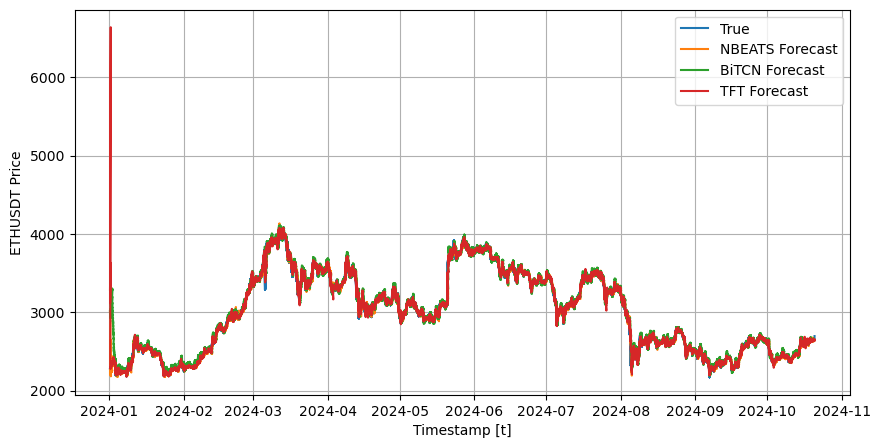

In [10]:

symbol='ETH/USDT'
ohlv_data=build_market_image(target_pair=symbol,time_frame='1h',axis=0,verbose=1,only_target=True)
data=prepare_forecast_data(model,ohlv_data,plot=True)
data=data[data['symbol']==target_pair.replace('/','')].copy()

data



In [11]:
split_date=datetime.datetime(year= 2024, month= 3, day=1)
end_date=split_date+datetime.timedelta(days=14)


data.index=pd.to_datetime(data['ds'])

symbol='ETHUSDT'
hf_data=data.copy()

hf_train_data=hf_data.groupby('symbol').apply(lambda x: x[:split_date])
hf_test_data=hf_data.groupby('symbol').apply(lambda x: x[split_date:end_date])

hf_train_data=hf_train_data.reset_index(level=0,drop=True).reset_index(drop=True)
hf_test_data=hf_test_data.reset_index(level=0,drop=True).reset_index(drop=True)


trade_data=data[data['symbol']==symbol].copy()
train_data=trade_data[:split_date].reset_index(drop=True)
test_data=trade_data[split_date:end_date].reset_index(drop=True)
test_data.columns

Index(['ds', 'close', 'symbol', 'feature_NBEATS_H0', 'feature_NBEATS_H1',
       'feature_NBEATS_H2', 'feature_NBEATS_H3', 'feature_NBEATS_H4',
       'feature_NBEATS_H5', 'feature_NBEATS_H6', 'feature_BiTCN_H0',
       'feature_BiTCN_H1', 'feature_BiTCN_H2', 'feature_BiTCN_H3',
       'feature_BiTCN_H4', 'feature_BiTCN_H5', 'feature_BiTCN_H6',
       'feature_TFT_H0', 'feature_TFT_H1', 'feature_TFT_H2', 'feature_TFT_H3',
       'feature_TFT_H4', 'feature_TFT_H5', 'feature_TFT_H6',
       'feature_hour_of_day', 'feature_day_of_week', 'feature_day_of_month',
       'feature_day_of_year'],
      dtype='object')

In [12]:
train_data['close'].isna().sum()


0

In [13]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']="1"


In [14]:
# Shape Ratio reward function
def sharpe_reward_function(history):
        return float(history["portfolio_valuation", -1] /(np.std(history["portfolio_valuation"])+1e-7))


In [15]:
train_env_config=dict(
                name='ETHUSDT_train',
                reward_function=sharpe_reward_function,
                df = train_data, # Your dataset with your custom features
                positions = [ -1, -.5, 0, .5 , 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
                trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
                borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
                max_episode_duration=168,
                verbose=0
                )

test_env_config=copy.deepcopy(train_env_config)
test_env_config['name']='ETHUSDT_test'
test_env_config['df'] = test_data




In [16]:
train_env=TradingEnv(**train_env_config)

In [17]:
obs,info=train_env.reset()
obs.shape

(27,)

In [18]:
train_env.df.tail(5)

,ds,close,symbol,feature_NBEATS_H0,feature_NBEATS_H1,feature_NBEATS_H2,feature_NBEATS_H3,feature_NBEATS_H4,feature_NBEATS_H5,feature_NBEATS_H6,...,feature_TFT_H3,feature_TFT_H4,feature_TFT_H5,feature_TFT_H6,feature_hour_of_day,feature_day_of_week,feature_day_of_month,feature_day_of_year,dynamic_feature__0,dynamic_feature__1
1429,2024-02-29 20:00:00,3403.12,ETHUSDT,3396.788086,3396.415283,3392.920410,3397.260498,3398.673340,3395.275879,3397.363037,...,3393.006348,3392.767090,3393.593994,3395.987793,0.369565,0.000000,0.433333,-0.338356,0,0
1430,2024-02-29 21:00:00,3397.16,ETHUSDT,3393.324707,3392.805176,3390.365234,3393.104004,3394.378906,3390.653809,3389.762451,...,3398.368896,3400.140381,3401.566650,3403.194580,0.413043,0.000000,0.433333,-0.338356,0,0
1431,2024-02-29 22:00:00,3347.77,ETHUSDT,3360.741943,3370.025391,3381.198975,3392.147705,3394.107666,3386.526855,3380.668457,...,3394.821777,3405.018799,3411.692627,3415.883301,0.456522,0.000000,0.433333,-0.338356,0,0
1432,2024-02-29 23:00:00,3331.70,ETHUSDT,3350.638672,3363.253418,3367.151123,3372.327637,3370.314453,3365.034424,3360.159180,...,3380.781982,3391.090820,3396.425049,3399.547607,0.500000,0.000000,0.433333,-0.338356,0,0
1433,2024-03-01 00:00:00,3345.28,ETHUSDT,3361.549316,3375.292236,3381.935303,3387.061035,3388.708496,3384.804443,3381.698242,...,3342.144043,3336.880371,3333.541992,3332.056152,-0.500000,0.166667,-0.500000,-0.335616,0,0


In [19]:
obs=train_env.reset()
terminated = truncated = False
# env.action_space.sa
while not terminated and not truncated:
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.step(action)
info['reward']
train_env.results_metrics
info

{'idx': 882,
 'step': 167,
 'date': 882,
 'position_index': 2,
 'position': 0,
 'real_position': 0.0,
 'data_close': 2382.72,
 'data_symbol': 'ETHUSDT',
 'data_ds': Timestamp('2024-02-07 01:00:00'),
 'portfolio_valuation': 908.90734124655,
 'portfolio_distribution_asset': 0,
 'portfolio_distribution_fiat': 908.90734124655,
 'portfolio_distribution_borrowed_asset': 0,
 'portfolio_distribution_borrowed_fiat': 0,
 'portfolio_distribution_interest_asset': 0.0,
 'portfolio_distribution_interest_fiat': 0.0,
 'reward': 38.62653722977903}

In [20]:


register_env("train_env", lambda config: TradingEnv(**train_env_config))
register_env("test_env", lambda config: TradingEnv(**test_env_config))
register_env("test_env", lambda config: gym.make('TradingEnv'))


In [21]:

def trial_str_creator(trial):
    return "{}_{}_trading_agent".format(trial.trainable_name, trial.trial_id)



In [22]:
# type(float(np.float64(1660)))

In [23]:
class TraderCallbacks(DefaultCallbacks):
    
    def on_episode_start(
            self,
            *,
            worker: RolloutWorker,
            base_env: BaseEnv,
            policies: Dict[str, Policy],
            episode: Episode,
            env_index: int,
            **kwargs,
        ):
        # Make sure this episode has just been started (only initial obs
        # logged so far).


        # Create lists to store angles in
        episode.hist_data["portfolio_values"] = []
        episode.hist_data["positions"] = []

    def on_episode_step(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs,
    ):
        # Make sure this episode is ongoing.

        portfolio_valuation = episode.last_info_for()['portfolio_valuation']
        position=episode.last_info_for()['position']
        episode.hist_data["portfolio_values"].append(portfolio_valuation)
        episode.hist_data["positions"].append(position)

        
    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs,
    ):


        portfolio_valuation = episode.hist_data["portfolio_values"][-1]
        position_changes = np.sum(np.diff(episode.hist_data["positions"]) != 0)
        # m_port=np.mean(position_changes)
        
        episode.custom_metrics["portfolio_value"] = float(portfolio_valuation)
        episode.custom_metrics["position_changes"] = float(position_changes)
        # train.report(episode.custom_metrics)
        


In [24]:

ppo_algo = (PPOConfig().training(lr=ray.tune.loguniform(1e-8, 1e-5),
                         gamma=ray.tune.loguniform(.8, .999),      
                         lambda_=ray.tune.loguniform(.9, 1),
                         vf_loss_coeff=ray.tune.loguniform(.5, 1),     
                         kl_coeff=ray.tune.loguniform(.003,.3),
                         num_sgd_iter=ray.tune.randint(3,30),
                         clip_param=ray.tune.choice([.1,.2,.3]),
                         model={
                             'fcnet_hiddens': ray.tune.choice([[128,128],[256,256],[512,512],[1024,1024]]),
                            #  'use_attention':True,#tune.choice([True,False]),

                                },

                         )

                        .resources(
                                    num_gpus=0,
                                    
                                    )
                        .callbacks(TraderCallbacks)
                        .reporting(keep_per_episode_custom_metrics=False)
                        .environment(env="train_env")
                        .debugging(log_level='ERROR')
                            
                        .evaluation(
                                    evaluation_config={

                                                        "env": 'test_env',  # The dictionary we built before (only the overriding keys to use in evaluation)
                                                        "explore": False,
                                                        }
                                    )
                        
            
            )

ppo_algo_config=ppo_algo.to_dict()
ppo_algo_config.pop('num_gpus_per_worker')
ppo_algo_config.pop('num_cpus_per_worker')
ppo_algo_config.pop('num_cpus_per_learner_worker')
ppo_algo_config.pop('num_gpus_per_learner_worker')
ppo_algo_config.pop('num_learner_workers')
ppo_algo_config['num_cpus_per_env_runner']=2
ppo_algo_config['num_gpus_per_env_runner']=0

ppo_algo_config['num_cpus_per_learner']=1
ppo_algo_config['num_gpus_per_learner']=1
pprint(ppo_algo_config)

{'_AlgorithmConfig__prior_exploration_config': None,
 '_disable_action_flattening': False,
 '_disable_execution_plan_api': -1,
 '_disable_initialize_loss_from_dummy_batch': False,
 '_disable_preprocessor_api': False,
 '_enable_rl_module_api': -1,
 '_env_to_module_connector': None,
 '_evaluation_parallel_to_training_wo_thread': False,
 '_fake_gpus': False,
 '_is_atari': None,
 '_learner_class': None,
 '_learner_connector': None,
 '_model_config_dict': {},
 '_module_to_env_connector': None,
 '_per_module_overrides': {},
 '_rl_module_spec': None,
 '_run_training_always_in_thread': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_mask_key': 'action_mask',
 'action_space': None,
 'actions_in_input_normalized': False,
 'add_default_connectors_to_env_to_module_pipeline': True,
 'add_default_connectors_to_learner_pipeline': True,
 'add_default_connectors_to_module_to_env_pipeline': True,
 'algorithm_config_overrides_per_module': {},
 'always_attach_evaluation_results': True,
 '

In [25]:
# ppo_algo.build()

In [26]:
# First, get the handle for the logger you want to modify
loggers=["ray.data","ray.tune","ray.rllib","ray.train","ray.serve","ray"]
for logger in loggers:
    ray_logger=logging.getLogger(logger)
    ray_logger .setLevel(logging.ERROR)

In [27]:
logger = logging.getLogger("ray")
logger.setLevel(logging.ERROR)

In [28]:
ray.init(include_dashboard=False,
        #  _temp_dir='~/Users/sebastiancoombs/Documents/Git/MultiTrader/Rayrl_tune/tmp',
        #  dashboard_host="0.0.0.0"
         )

2024-10-21 13:51:37,930	INFO worker.py:1749 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.23.0


In [29]:
checkpoint_path='/Users/sebastiancoombs/Documents/Git/MultiTrader/Agent/checkpoints'

checkpoint_config=ray.train.CheckpointConfig(checkpoint_at_end=True,
                                         checkpoint_score_attribute='env_runners/custom_metrics/portfolio_value_mean',
                                        #  checkpoint_score_attribute='env_runners/episode_reward_mean',
                                        #  num_to_keep=1,
                                        #  checkpoint_frequency=10,
                                         )
reporter= JupyterNotebookReporter(
    sort_by_metric=True,
    metric='env_runners/custom_metrics/portfolio_value_max',
    mode='max',


    metric_columns={
                    'training_iteration':'iter',
                    'env_runners/reward':'reward',
                    'env_runners/custom_metrics/portfolio_value_mean': 'account_value_mean',
                    'env_runners/custom_metrics/position_changes_mean': 'n_trades_mean',
                    'env_runners/episode_reward_mean':'sharpe_ratio_mean',

                    'env_runners/custom_metrics/portfolio_value_max':'account_value_max',
                    'env_runners/custom_metrics/portfolio_value_min': 'account_value_min',

                    'env_runners/custom_metrics/position_changes_max': 'n_trades_max',
                    
                    'env_runners/episode_reward_max': 'sharpe_ratio_max',
                    'env_runners/episode_reward_min':'sharpe_ratio_min',
                    'env_runners/custom_metrics/portfolio_value_min': 'account_value_min',
                    

    },
    parameter_columns={

                        'lr':'lr',
                        'gamma':'gamma',
                        'lambda_':'lambda',
                        'kl_coeff':'kl_coeff',
                        'vf_loss_coeff':'vf_loss_coeff',
                        'num_sgd_iter':'num_sgd_iter',
                        'model/fcnet_hiddens':'fcnet_hiddens',
                        # 'model/use_attention':'use_attention'
                        }
    )

run_config=ray.train.RunConfig(

                            stop={
                                "training_iteration": 500,
                                #   "evaluation/episode_reward_mean": 1.5,
                                #   "timesteps_total":5000,
                                },
                                
                            
                            storage_path=checkpoint_path,
                            checkpoint_config=checkpoint_config,
                            progress_reporter=reporter

                        )

# search_algo = OptunaSearch(
#                             mode="max",                            
#                             metric='env_runners/custom_metrics/portfolio_value_mean',
# )



search_algo = HyperOptSearch(
    metric='env_runners/custom_metrics/portfolio_value_mean',
                            #  metric='episode_reward_mean',
                            
                             mode='max',
                             )

search_algo= ConcurrencyLimiter(
                                search_algo, 
                                max_concurrent=4
                                )

tune_config=ray.tune.TuneConfig(num_samples=20,
                            reuse_actors=False,
                            search_alg=search_algo,
                            trial_name_creator=trial_str_creator,
                            trial_dirname_creator=trial_str_creator,

                            )
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">') # make sure the path is correct, it fails silently otherwise
display(css)
tuner = ray.tune.Tuner(
    "PPO",
    param_space=ppo_algo_config,
    tune_config=tune_config,
    run_config=run_config,
    )
appo_results=tuner.fit()

(PPO pid=7792) Install gputil for GPU system monitoring.
(PPO pid=7806) Install gputil for GPU system monitoring.
(PPO pid=7806) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sebastiancoombs/Documents/Git/MultiTrader/Agent/checkpoints/PPO_2024-10-21_13-51-38/PPO_ab24efb2_trading_agent/checkpoint_000000)
(PPO pid=10298) Install gputil for GPU system monitoring.
(PPO pid=10298) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sebastiancoombs/Documents/Git/MultiTrader/Agent/checkpoints/PPO_2024-10-21_13-51-38/PPO_fd5e9cc5_trading_agent/checkpoint_000000)
(PPO pid=16456) Install gputil for GPU system monitoring.
(PPO pid=7792) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sebastiancoombs/Documents/Git/MultiTrader/Agent/checkpoints/PPO_2024-10-21_13-51-38/PPO_ca85de22_trading_agent/checkpoint_000000)
(PPO pid=16604) Install gputil for GPU system monitoring.
(PPO pid=16456) Checkpoint successfully creat

In [30]:


# appo_results=tuner.fit()

In [31]:
df_results = appo_results.get_dataframe()
df_results.to_csv('Rayrl_tune/results/appo_tune.csv')
# df_results

In [32]:

custom_cols=[
                'config/lr',
                'config/gamma',
                'config/lambda',
                'config/kl_coeff',
                'config/model/fcnet_hiddens',

                ]
custom_cols+=[c for c in df_results.filter(like='episode_reward').columns]
custom_cols+=[c for c in df_results.filter(like='custom_metrics').columns]
custom_cols=[c for c in custom_cols if 'sampler_results' not in c ]
custom_cols=[c for c in custom_cols if 'hist_stats' not in c ]
custom_cols=list(set(custom_cols))

In [33]:

df_results[custom_cols].sort_values('env_runners/custom_metrics/portfolio_value_mean',ascending=False)


,config/keep_per_episode_custom_metrics,config/gamma,env_runners/custom_metrics/portfolio_value_max,env_runners/episode_reward_min,config/lambda,config/lr,env_runners/episode_reward_mean,env_runners/custom_metrics/portfolio_value_min,env_runners/custom_metrics/position_changes_max,env_runners/custom_metrics/portfolio_value_mean,env_runners/custom_metrics/position_changes_min,env_runners/episode_reward_max,config/kl_coeff,env_runners/custom_metrics/position_changes_mean,config/model/fcnet_hiddens
13,False,0.862834,1021.978200,2.505806e+05,0.914120,3.591087e-08,2.038074e+11,980.293899,10.0,1000.242296,0.0,1.670000e+12,0.008967,2.80,"(1024, 1024)"
5,False,0.970670,1012.833968,2.893422e+05,0.982761,1.170254e-07,2.884113e+11,988.191996,6.0,999.988155,0.0,1.670000e+12,0.009481,1.68,"(1024, 1024)"
16,False,0.962541,1004.793979,1.469116e+07,0.963303,9.449466e-07,2.505192e+11,999.899990,2.0,999.986436,0.0,1.670000e+12,0.009316,0.02,"(128, 128)"
9,False,0.864885,1000.000000,1.469116e+07,0.912801,1.108732e-06,4.342169e+11,999.899990,0.0,999.946498,0.0,1.670000e+12,0.248899,0.00,"(1024, 1024)"
2,False,0.944965,1000.000000,1.469116e+07,0.924437,2.730115e-06,4.008163e+11,999.899990,0.0,999.941497,0.0,1.670000e+12,0.147451,0.00,"(256, 256)"
7,False,0.806890,1000.000000,1.469116e+07,0.946488,2.313233e-07,3.006178e+11,999.899990,0.0,999.937497,0.0,1.670000e+12,0.004145,0.00,"(512, 512)"
18,False,0.800435,1000.000000,1.469116e+07,0.930266,3.316321e-06,2.505190e+11,999.899990,0.0,999.936997,0.0,1.670000e+12,0.012916,0.00,"(256, 256)"
4,False,0.937972,1000.000000,1.469116e+07,0.905153,1.232399e-07,2.839179e+11,999.899990,0.0,999.936496,0.0,1.670000e+12,0.003502,0.00,"(1024, 1024)"
10,False,0.867704,1000.000000,8.817604e+06,0.913734,4.604698e-06,3.841182e+11,997.854224,2.0,999.926040,0.0,1.670000e+12,0.089667,0.02,"(128, 128)"
8,False,0.857133,1000.000000,1.915135e+06,0.974850,6.010332e-06,4.008156e+11,997.998898,2.0,999.920486,0.0,1.670000e+12,0.107930,0.02,"(256, 256)"


In [34]:
# [c for c in df_results.columns]

In [35]:
best=appo_results.get_best_result(metric='env_runners/custom_metrics/portfolio_value_max', mode='max')
best.checkpoint

Checkpoint(filesystem=local, path=/Users/sebastiancoombs/Documents/Git/MultiTrader/Agent/checkpoints/PPO_2024-10-21_13-51-38/PPO_1d641536_trading_agent/checkpoint_000000)

In [36]:
from ray.rllib.algorithms.algorithm import Algorithm

In [37]:
agent= Algorithm.from_checkpoint(best.checkpoint.path)

In [38]:
num_epochs=1000
for i in tqdm(range(num_epochs)):
    agent.train()
    if i % 100 == 0:
        checkpoint_dir = agent.save('Agent/final_checkpoints').checkpoint.path
        print(f"Checkpoint saved in directory {checkpoint_dir}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints


In [41]:
test_env=TradingEnv(**test_env_config)

In [42]:
obs,info=train_env.reset()
action=None
reward=0
terminated = truncated = False

while not terminated and not truncated:

    action = agent.compute_single_action(obs,explore=False)
    action = train_env.action_space.sample()
    # print(action)
    next_obs, reward, terminated, truncated, info = train_env.step(action)

    obs=next_obs
info
train_env.get_metrics(),info['portfolio_valuation']

({'Market Return': '17.20%', 'Portfolio Return': '-0.95%'}, 990.4999734236374)

  0%|          | 0/100 [00:00<?, ?it/s]

999.9424966996697

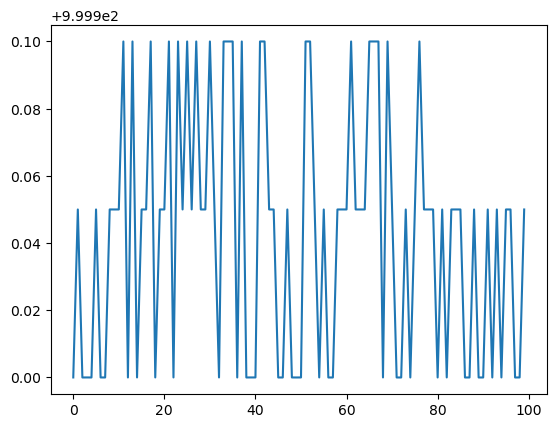

In [43]:
eval_profit=[]
for i in tqdm( range(100)):
    obs,info=train_env.reset()
    action=None
    reward=0
    terminated = truncated = False

    while not terminated and not truncated:

        action = agent.compute_single_action(obs,explore=False)
        # action = train_env.action_space.sample()
        # print(action)
        next_obs, reward, terminated, truncated, info = train_env.step(action)

        obs=next_obs

    eval_profit.append(info['portfolio_valuation'])
    info['portfolio_valuation']
profits=[e for e in eval_profit]
plt.plot(profits)
np.mean(profits)

In [44]:
eval_profit=[]
for i in tqdm( range(100)):
    obs,info=test_env.reset()
    action=None
    reward=0
    terminated = truncated = False

    while not terminated and not truncated:

        action = agent.compute_single_action(obs,explore=False)
        # action = train_env.action_space.sample()
        # print(action)
        next_obs, reward, terminated, truncated, info = test_env.step(action)

        obs=next_obs

    eval_profit.append(info['portfolio_valuation'])
    info['portfolio_valuation']


  0%|          | 0/100 [00:00<?, ?it/s]

999.9459974497447

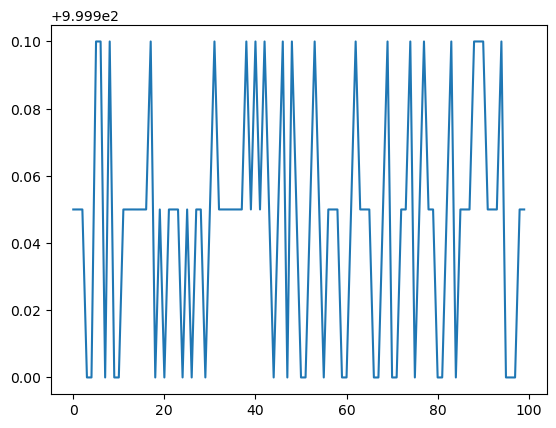

In [45]:

plt.plot(eval_profit)
np.mean(eval_profit)

In [48]:
test_env.max_episode_duration=168

In [63]:
obs,info=test_env.reset()
action=None
reward=0
terminated = truncated = False

while not terminated and not truncated:

    action = agent.compute_single_action(obs,explore=False)
    # action = train_env.action_space.sample()
    # print(action)
    next_obs, reward, terminated, truncated, info = test_env.step(action)

    obs=next_obs


info['portfolio_valuation']

1000.0

In [ ]:
test_env.save_for_render(dir = "PPO_test_render_logs")

In [ ]:
renderer = Renderer(render_logs_dir="PPO_test_render_logs")

In [ ]:
# Add Custom Metrics (Annualized metrics)
renderer.add_metric(
    name = "Annual Market Return",
    function = lambda df : f"{ ((df['close'].iloc[-1] / df['close'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)
renderer.add_metric(
        name = "Annual Portfolio Return",
        function = lambda df : f"{((df['portfolio_valuation'].iloc[-1] / df['portfolio_valuation'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)

renderer.run()